## Convert CSV to Images with Balancing and Shuffling

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils import shuffle

# Input and output directories
input_train_csv = 'data/fashion-mnist_train.csv'
input_test_csv = 'data/fashion-mnist_test.csv'
output_dir = 'mini_dataset'

# Create the output directory structure
def create_output_dirs(base_dir, classes):
    for label in classes:
        os.makedirs(os.path.join(base_dir, str(label)), exist_ok=True)

# Load and shuffle the data
def load_and_shuffle_data(file_path, random_state=42):
    data = pd.read_csv(file_path)
    data = shuffle(data, random_state=random_state)
    return data

# Get a balanced subset of the data
def get_balanced_subset(data, samples_per_class):
    balanced_data = pd.DataFrame()
    for label in range(10):  # Assuming labels are from 0 to 9
        class_data = data[data.iloc[:, 0] == label]  # Filter rows for the label
        balanced_data = pd.concat([balanced_data, class_data[:samples_per_class]])
    return shuffle(balanced_data)

# Save data as images
def save_images(data, output_base_dir):
    for index, row in data.iterrows():
        label = row[0]  # First column is the label
        pixels = row[1:].values.reshape(28, 28).astype('uint8')  # Reshape to 28x28
        image = Image.fromarray(pixels)  # Convert to image
        image_path = os.path.join(output_base_dir, str(label), f"{index}.png")
        image.save(image_path)

# Main process
def process_data(train_csv, test_csv, output_base_dir, samples_ratio=0.5):
    # Load and shuffle the data
    train_data = load_and_shuffle_data(train_csv)
    test_data = load_and_shuffle_data(test_csv)

    # Get the number of samples per class
    total_train_samples = int(len(train_data) * samples_ratio)  # 50% of the training data
    total_test_samples = int(len(test_data) * samples_ratio)    # 50% of the test data
    samples_per_class_train = total_train_samples // 10  # Balance across 10 classes
    samples_per_class_test = total_test_samples // 10

    # Get balanced subsets
    mini_train = get_balanced_subset(train_data, samples_per_class_train)
    mini_test = get_balanced_subset(test_data, samples_per_class_test)

    # Create output directories
    train_output_dir = os.path.join(output_base_dir, 'train')
    test_output_dir = os.path.join(output_base_dir, 'test')
    create_output_dirs(train_output_dir, range(10))
    create_output_dirs(test_output_dir, range(10))

    # Save the images
    print("Saving training images...")
    save_images(mini_train, train_output_dir)
    print("Saving testing images...")
    save_images(mini_test, test_output_dir)
    print(f"Mini dataset saved in '{output_base_dir}'.")

# Run the process
process_data(input_train_csv, input_test_csv, output_dir)


Saving training images...
Saving testing images...
Mini dataset saved in 'mini_dataset'.


## Import Libraries and Set Paths

In [2]:
# Import necessary libraries
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define paths for data and model output
data_dir = "mini_dataset/train"  # Directory containing training data
model_save_path = "fashion_mnist_cnn_model.h5"  # Path to save the trained model

# Define image properties and batch size
img_height, img_width = 28, 28  # Image dimensions
batch_size = 32  # Batch size for training


## Data Augmentation and Preprocessing

In [3]:
# Data augmentation and preprocessing settings
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to the range [0, 1]
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
    zoom_range=0.1,  # Randomly zoom in/out by up to 10%
    shear_range=0.1,  # Apply random shearing transformations
    validation_split=0.2  # Split the dataset into 80% training and 20% validation
)

# Load and preprocess training data
train_generator = datagen.flow_from_directory(
    data_dir,  # Directory containing the dataset
    target_size=(img_height, img_width),  # Resize all images to the same dimensions
    batch_size=batch_size,  # Number of images per batch
    color_mode="grayscale",  # Load images as grayscale
    class_mode="categorical",  # Use categorical labels for multi-class classification
    subset="training",  # Use the training portion of the dataset
    shuffle=True  # Shuffle the data for better generalization
)

# Load and preprocess validation data
validation_generator = datagen.flow_from_directory(
    data_dir,  # Directory containing the dataset
    target_size=(img_height, img_width),  # Resize all images to the same dimensions
    batch_size=batch_size,  # Number of images per batch
    color_mode="grayscale",  # Load images as grayscale
    class_mode="categorical",  # Use categorical labels for multi-class classification
    subset="validation"  # Use the validation portion of the dataset
)


Found 24000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.


## Build the CNN Model

In [4]:
# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 1)),  # First convolutional layer
    MaxPooling2D((2, 2)),  # First pooling layer
    Conv2D(64, (3, 3), activation="relu"),  # Second convolutional layer
    MaxPooling2D((2, 2)),  # Second pooling layer
    Flatten(),  # Flatten the feature maps into a 1D vector
    Dense(128, activation="relu"),  # Fully connected layer with 128 neurons
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(10, activation="softmax")  # Output layer with 10 neurons for 10 classes
])

# Compile the model
model.compile(
    optimizer="adam",  # Adam optimizer for adaptive learning rate
    loss="categorical_crossentropy",  # Loss function for multi-class classification
    metrics=["accuracy"]  # Monitor accuracy during training
)

# Display the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

## Train the Model

In [5]:
# Define callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,  # Stop training if no improvement for 5 epochs
    restore_best_weights=True  # Restore the best weights from training
)

checkpoint = ModelCheckpoint(
    model_save_path,  # Path to save the best model
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True  # Save only the model with the best validation loss
)


# Train the model
history = model.fit(
    train_generator,  # Training data
    validation_data=validation_generator,  # Validation data
    epochs=20,  # Maximum number of epochs
    callbacks=[early_stop, checkpoint]  # Callbacks for training
)


# Save the training history for later analysis
np.save("training_history.npy", history.history)

print(f"Model saved at {model_save_path}")


Epoch 1/20
750/750 [==============================] - 275s 365ms/step - loss: 0.9272 - accuracy: 0.6585 - val_loss: 0.6463 - val_accuracy: 0.7580
Epoch 2/20
  5/750 [..............................] - ETA: 20s - loss: 0.6518 - accuracy: 0.7312

C:\Users\laksi\anaconda3\envs\new_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 30s 40ms/step - loss: 0.6831 - accuracy: 0.7421 - val_loss: 0.5602 - val_accuracy: 0.7780
Epoch 3/20
750/750 [==============================] - 31s 41ms/step - loss: 0.6133 - accuracy: 0.7670 - val_loss: 0.5456 - val_accuracy: 0.7892
Epoch 4/20
750/750 [==============================] - 30s 40ms/step - loss: 0.5827 - accuracy: 0.7820 - val_loss: 0.4904 - val_accuracy: 0.8060
Epoch 5/20
750/750 [==============================] - 30s 40ms/step - loss: 0.5542 - accuracy: 0.7915 - val_loss: 0.4731 - val_accuracy: 0.8142
Epoch 6/20
750/750 [==============================] - 30s 39ms/step - loss: 0.5329 - accuracy: 0.8002 - val_loss: 0.4408 - val_accuracy: 0.8298
Epoch 7/20
750/750 [==============================] - 29s 39ms/step - loss: 0.5156 - accuracy: 0.8063 - val_loss: 0.4513 - val_accuracy: 0.8250
Epoch 8/20
750/750 [==============================] - 29s 39ms/step - loss: 0.4977 - accuracy: 0.8144 - val_loss: 0.4270 - val_accuracy: 0.8377
Epo

## Analyze Training Results

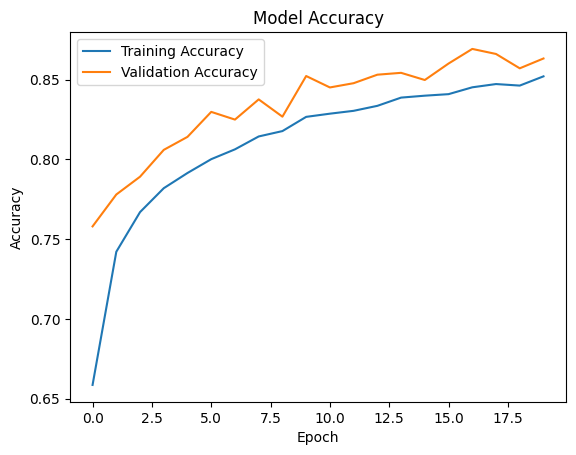

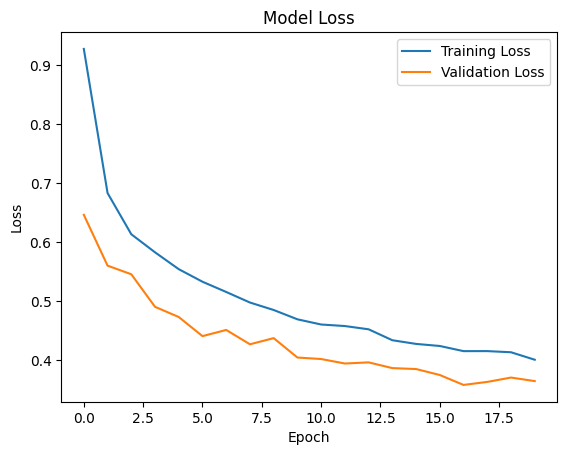

In [6]:
import matplotlib.pyplot as plt

# Load training history
history_data = np.load("training_history.npy", allow_pickle=True).item()

# Plot training and validation accuracy
plt.plot(history_data["accuracy"], label="Training Accuracy")
plt.plot(history_data["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_data["loss"], label="Training Loss")
plt.plot(history_data["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Resuming Training from the Saved Model for Additional Epochs

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("fashion_mnist_cnn_model.h5")

# Train the model for additional epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # New total epoch count
    initial_epoch=20,  # Start from the last epoch (20 in this case)
    callbacks=[early_stop, checkpoint]
)

# Save the updated training history
np.save("updated_training_history.npy", history.history)


Epoch 21/30
750/750 [==============================] - 31s 41ms/step - loss: 0.4112 - accuracy: 0.8479 - val_loss: 0.3753 - val_accuracy: 0.8602
Epoch 22/30
750/750 [==============================] - 30s 40ms/step - loss: 0.4085 - accuracy: 0.8515 - val_loss: 0.3570 - val_accuracy: 0.8640
Epoch 23/30
  4/750 [..............................] - ETA: 16s - loss: 0.5661 - accuracy: 0.8281

C:\Users\laksi\anaconda3\envs\new_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 31s 41ms/step - loss: 0.4075 - accuracy: 0.8525 - val_loss: 0.3545 - val_accuracy: 0.8650
Epoch 24/30
750/750 [==============================] - 30s 40ms/step - loss: 0.3985 - accuracy: 0.8524 - val_loss: 0.3574 - val_accuracy: 0.8670
Epoch 25/30
750/750 [==============================] - 30s 40ms/step - loss: 0.3981 - accuracy: 0.8517 - val_loss: 0.3509 - val_accuracy: 0.8648
Epoch 26/30
750/750 [==============================] - 30s 40ms/step - loss: 0.3961 - accuracy: 0.8530 - val_loss: 0.3628 - val_accuracy: 0.8600
Epoch 27/30
750/750 [==============================] - 31s 41ms/step - loss: 0.3888 - accuracy: 0.8553 - val_loss: 0.3411 - val_accuracy: 0.8703
Epoch 28/30
750/750 [==============================] - 31s 41ms/step - loss: 0.3861 - accuracy: 0.8566 - val_loss: 0.3629 - val_accuracy: 0.8583
Epoch 29/30
750/750 [==============================] - 31s 41ms/step - loss: 0.3806 - accuracy: 0.8598 - val_loss: 0.3820 - val_accuracy: 0.85

## Plot Combined Training History

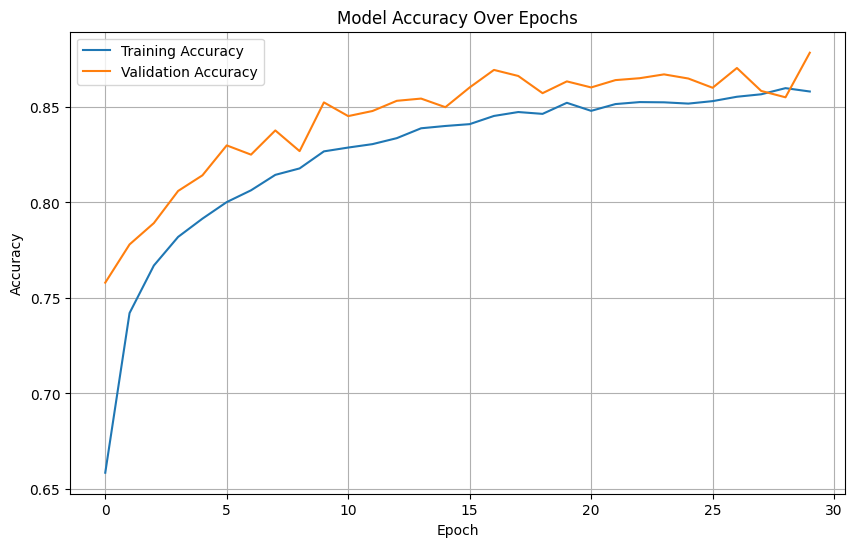

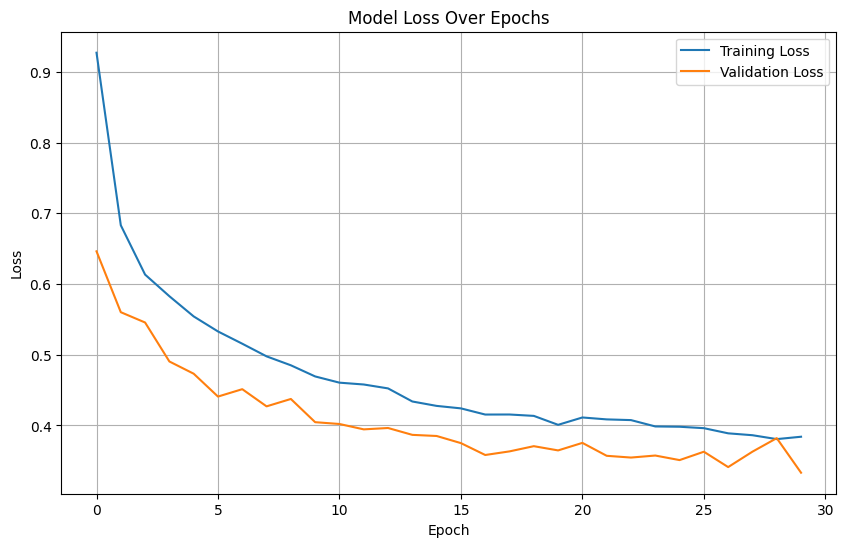

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load initial and updated training histories
initial_history = np.load("training_history.npy", allow_pickle=True).item()
updated_history = np.load("updated_training_history.npy", allow_pickle=True).item()

# Combine the histories
combined_accuracy = initial_history["accuracy"] + updated_history["accuracy"]
combined_val_accuracy = initial_history["val_accuracy"] + updated_history["val_accuracy"]
combined_loss = initial_history["loss"] + updated_history["loss"]
combined_val_loss = initial_history["val_loss"] + updated_history["val_loss"]

# Plot combined training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(combined_accuracy, label="Training Accuracy")
plt.plot(combined_val_accuracy, label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot combined training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(combined_loss, label="Training Loss")
plt.plot(combined_val_loss, label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Getting Smoothed Curves

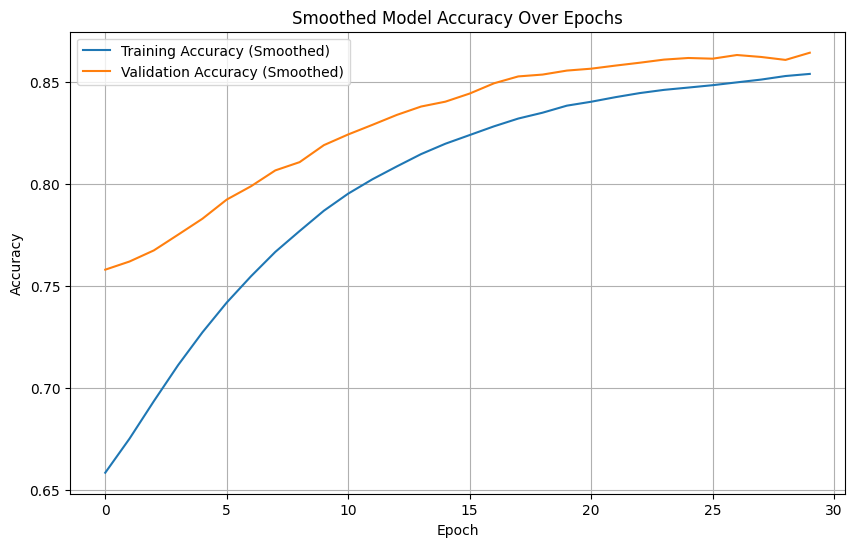

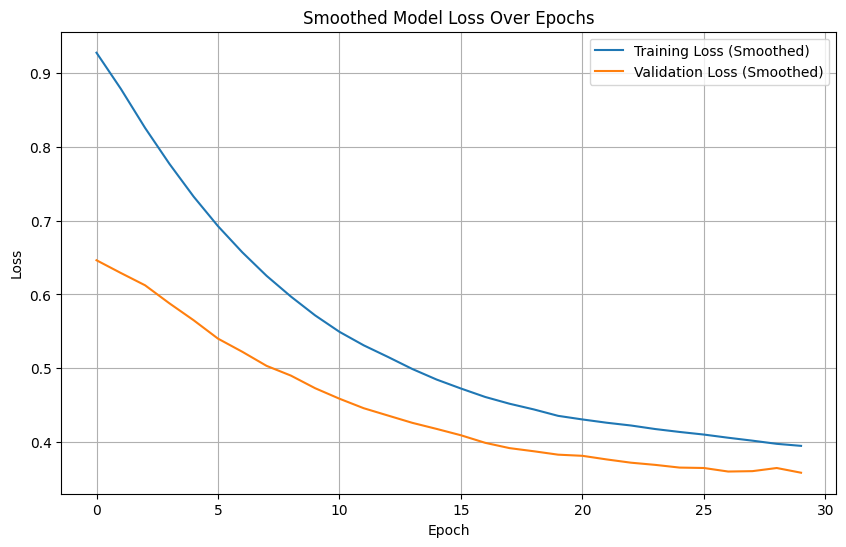

In [11]:
# Function to smooth the curve using a moving average
def smooth_curve(values, smoothing_factor=0.8):
    smoothed_values = []
    for i, value in enumerate(values):
        if i == 0:
            smoothed_values.append(value)
        else:
            smoothed_values.append(smoothing_factor * smoothed_values[-1] + (1 - smoothing_factor) * value)
    return smoothed_values

# Smooth the combined histories
smoothed_accuracy = smooth_curve(combined_accuracy)
smoothed_val_accuracy = smooth_curve(combined_val_accuracy)
smoothed_loss = smooth_curve(combined_loss)
smoothed_val_loss = smooth_curve(combined_val_loss)

# Plot smoothed training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(smoothed_accuracy, label="Training Accuracy (Smoothed)")
plt.plot(smoothed_val_accuracy, label="Validation Accuracy (Smoothed)")
plt.title("Smoothed Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot smoothed training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(smoothed_loss, label="Training Loss (Smoothed)")
plt.plot(smoothed_val_loss, label="Validation Loss (Smoothed)")
plt.title("Smoothed Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
